# Classify ECG based on pacing location

To familiarize yourself with ECG signals. +++

## Data set

The data set consist of six files: `np.mat, np1.mat, ap.mat, rp.mat, lp.mat, bp.mat`

* `np` is no pacing
* `ap` atrial pacing
* `rp` right ventricular pacing
* `lp` left ventricular pacing
* `bp` bi-ventricular (both left and right) pacing


The data is a three channel ECG, it contains lead I, aVF, and V3. 

Each file contains a different number of points. Calling `.shape` on the data will return `[N_i, 3]`, where `N_i` changes between the files. The data is recorded at 1000Hz, thus 1000 samples equals one second.

* **np**: Contains no pacing artifacts
* **ap**: Is recorded during atrial pacing, so it will contain one pacing spike per heartbeat
* **ap, lp, bp**: Pacing in the atrium, and one (or both) of the ventricles, so you'll see two spikes, with a short delay between them

## Reading the raw data

**todo:** Read the test of the data

In [1]:
from scipy import io
import numpy as np 


def read_data(filename):
    data = io.loadmat(filename)
    arr = np.squeeze(data['data'])
    return arr.reshape(-1, 3)
    

no_pace = read_data('np1.mat')
left_pace = read_data('lp.mat')

<IPython.core.display.Javascript object>


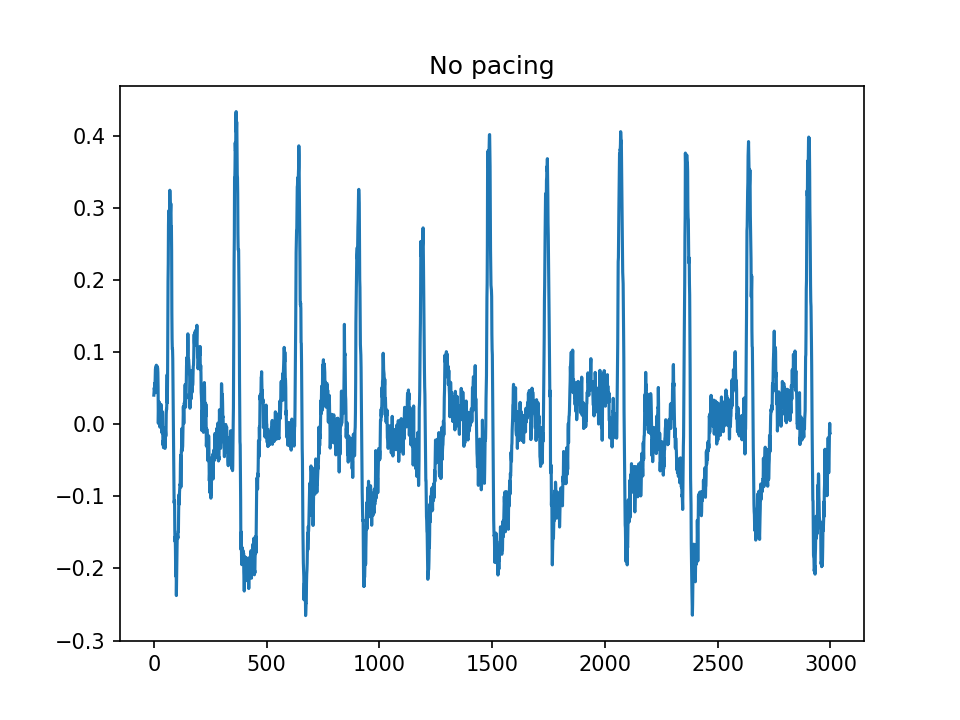

In [3]:
import matplotlib.pyplot as plt 
%matplotlib notebook


plt.figure()
plt.title('No pacing')
plt.plot(no_pace[9000:12000, 0])
plt.show()

<IPython.core.display.Javascript object>


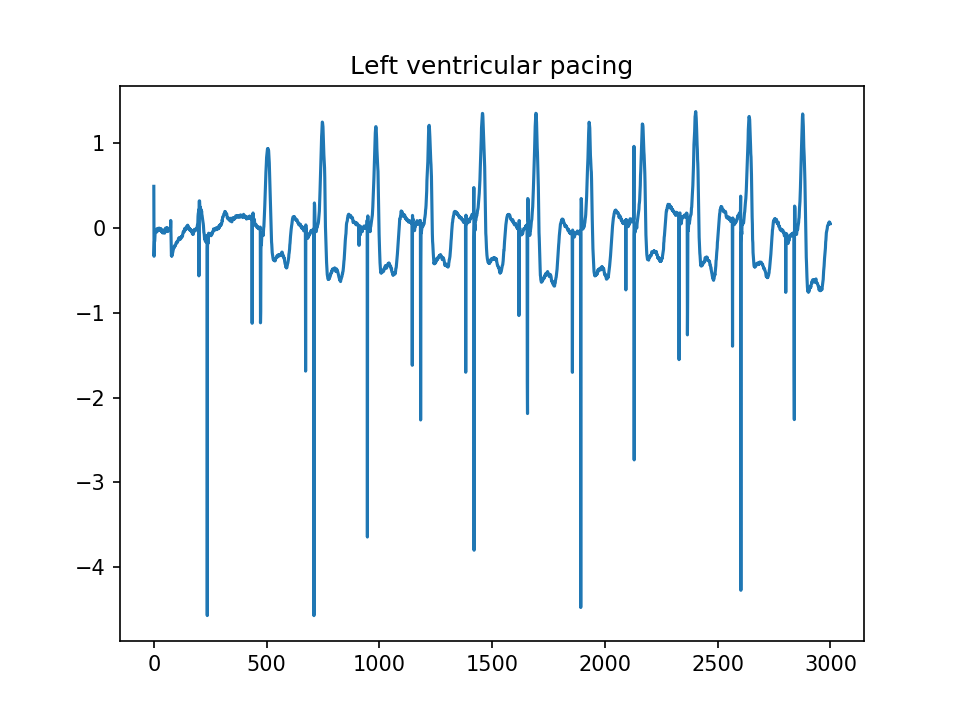

In [4]:
plt.figure()
plt.title('Left ventricular pacing')
plt.plot(left_pace[:3000, 0])
plt.show()

<IPython.core.display.Javascript object>


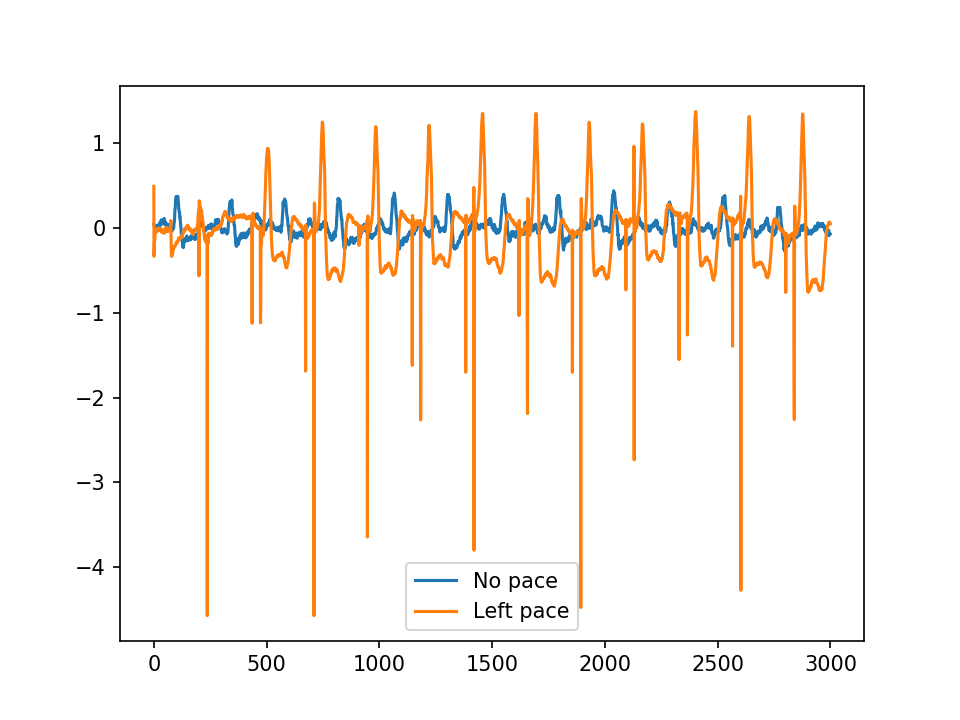

In [5]:
plt.figure()
plt.plot(no_pace[:3000, 0], label='No pace')
plt.plot(left_pace[:3000, 0], label='Left pace')
plt.legend()
plt.show()

### Collecting the data

Below we divide the continuous ECG signals into smaller chunks of size `chunk_size`. 

**todo**: do the same for the rest of the data

In [6]:
# Size of ECG segments
chunk_size = 500

# number of data points to discard such that the ECGs can 
# be divided into segments of size chunk_size
discard = no_pace.shape[0] % chunk_size

# remove said points
section = no_pace[:-discard]

# split the ecg recording into segments
section_np = np.asarray(np.array_split(section, section.shape[0] / chunk_size))

discard = left_pace.shape[0] % chunk_size
section = left_pace[:-discard]
section_lp = np.asarray(np.array_split(section, section.shape[0] / chunk_size))

print(no_pace.shape, left_pace.shape)
print(no_pace.max(), no_pace.min(), no_pace.mean(), no_pace.std(), sep='   ')
print(left_pace.max(), left_pace.min(), left_pace.mean(), left_pace.std(), sep='   ')



(164750, 3) (70200, 3)
1.1171875   -1.4415625   0.0026029968   0.15981801
2.449375   -4.9475   0.010223639   0.4225004


## Cluster

Below we calculate the mean and the standard deviation of each ecg segment, and use this data to form a new simple data set. 

For the raw data we have `no_pace[i].shape == [500, 3]`, by the simplification we get `no_pace_simple[i] = [no_pace[i].mean(), no_pace[i].std()]`.

<IPython.core.display.Javascript object>


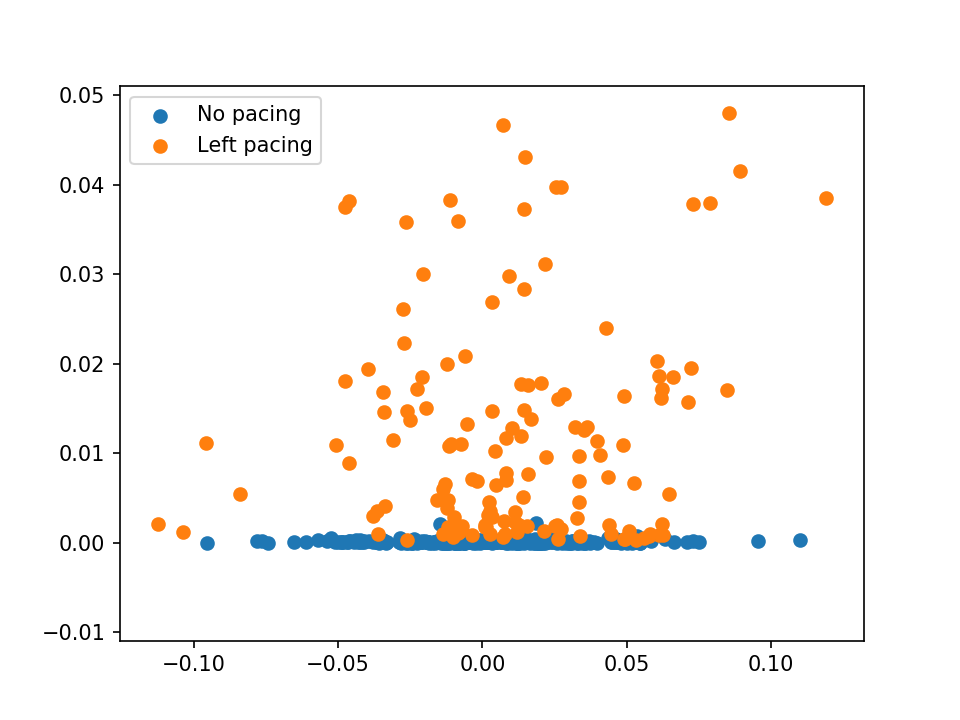

In [7]:
x = np.concatenate((section_np, section_lp), axis=0)
means = np.squeeze(np.apply_over_axes(np.mean, x, axes=[1, 2]))
stds = np.squeeze(np.apply_over_axes(np.std, x, axes=[1, 2]))
x = np.concatenate((means[:, np.newaxis], stds[:, np.newaxis]), axis=1)

stop_np = section_np.shape[0]

plt.figure()
plt.scatter(x[:stop_np, 0], x[:stop_np, 1], label='No pacing')
plt.scatter(x[stop_np:, 0], x[stop_np:, 1], label='Left pacing')
plt.legend()
plt.show()


##### KMeans

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
SEED = 0 # set to None for random

# Create label
# no pacing = 0
# left pacing = 1
no_pacing = np.zeros(section_np.shape[0])
left_pacing = np.ones(section_lp.shape[0])
y = np.concatenate((no_pacing, left_pacing), axis=0)

# Shuffle the samples 
idx = np.arange(x.shape[0])
np.random.seed(SEED)
np.random.shuffle(idx)

x_data = x[idx]
labels = y[idx]

x_train, x_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.33, random_state=SEED)

kmeans = KMeans(n_clusters=2)
train_pred = kmeans.fit_predict(x_train)
test_pred = kmeans.predict(x_test)

print('Train accuracy:', sum(train_pred == y_train) / y_train.size)
print('Test accuracy:', sum(test_pred == y_test) / y_test.size)

Train accuracy: 0.5605095541401274
Test accuracy: 0.5741935483870968


## Classification with kNN and SVM

In this section we use the simplified data set we created above to do classification. 

### kNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# create a new train test split. One for cross validation and
# a small part we only use for testing
x_cv, x_test, y_cv, y_test = train_test_split(x_data, labels, test_size=0.1, random_state=SEED)

classifier = KNeighborsClassifier(n_neighbors=1)
search_params = {
    'n_neighbors': list(range(3, 20, 3))
    # Can we achieve better performance by adding more params to the search?
    # See parameters here: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
}

# Perform a grid search with cross validation to find best estimator
search = GridSearchCV(classifier, search_params, cv=4)
search.fit(x_cv, y_cv)
print(search.best_params_)

train_pred = search.best_estimator_.predict(x_cv)
test_pred = search.best_estimator_.predict(x_test)
print('Train accuracy:', sum(train_pred == y_cv) / y_cv.size)
print('Test accuracy:', sum(test_pred == y_test) / y_test.size)

{'n_neighbors': 3}
Train accuracy: 0.95260663507109
Test accuracy: 0.9787234042553191


### SVM

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

x_cv, x_test, y_cv, y_test = train_test_split(x_data, labels, test_size=0.1, random_state=SEED)


classifier = SVC(gamma='auto')
search_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.linspace(1e-6, 10, 100)
}

search = GridSearchCV(classifier, search_params, cv=4)
search.fit(x_cv, y_cv)
print(search.best_params_)

train_pred = search.best_estimator_.predict(x_cv)
test_pred = search.best_estimator_.predict(x_test)

print('Train accuracy:', sum(train_pred == y_cv) / y_cv.size)
print('Test accuracy:', sum(test_pred == y_test) / y_test.size)

{'C': 1e-06, 'kernel': 'linear'}
Train accuracy: 0.6848341232227488
Test accuracy: 0.851063829787234


### Can we use deep learning?

Is it possible to get better results utilizing techniques from deep learning? Why/why not?

Install Keras, https://keras.io/. Use these examples as a starting point: https://github.com/keras-team/keras/tree/master/examples. There you'll find everything from very simple network architectures to state-of-the-art

### tasks

1. Extend the methods above the use ecg samples, not just the mean and std. 
2. Extend the data set to all pacing locations.
3. Find a better way for splitting the data. 500 points (0.5 seconds) is not the best
4. Use data preprocessing to improve the results


The expectation is above 90% correct classification on the full data set.